In [1]:
import subprocess

import graphviz
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from utils import definitions as defs

In [2]:
df = pd.read_excel(defs.ETLED_DATA_PATH)

y = df['Метка']
X = df.drop('Метка', axis=1)

feature_names = list(X)
feature_names = [i[:15] for i in feature_names]

In [3]:
model = DecisionTreeClassifier()
model.fit(X, y)

DecisionTreeClassifier()

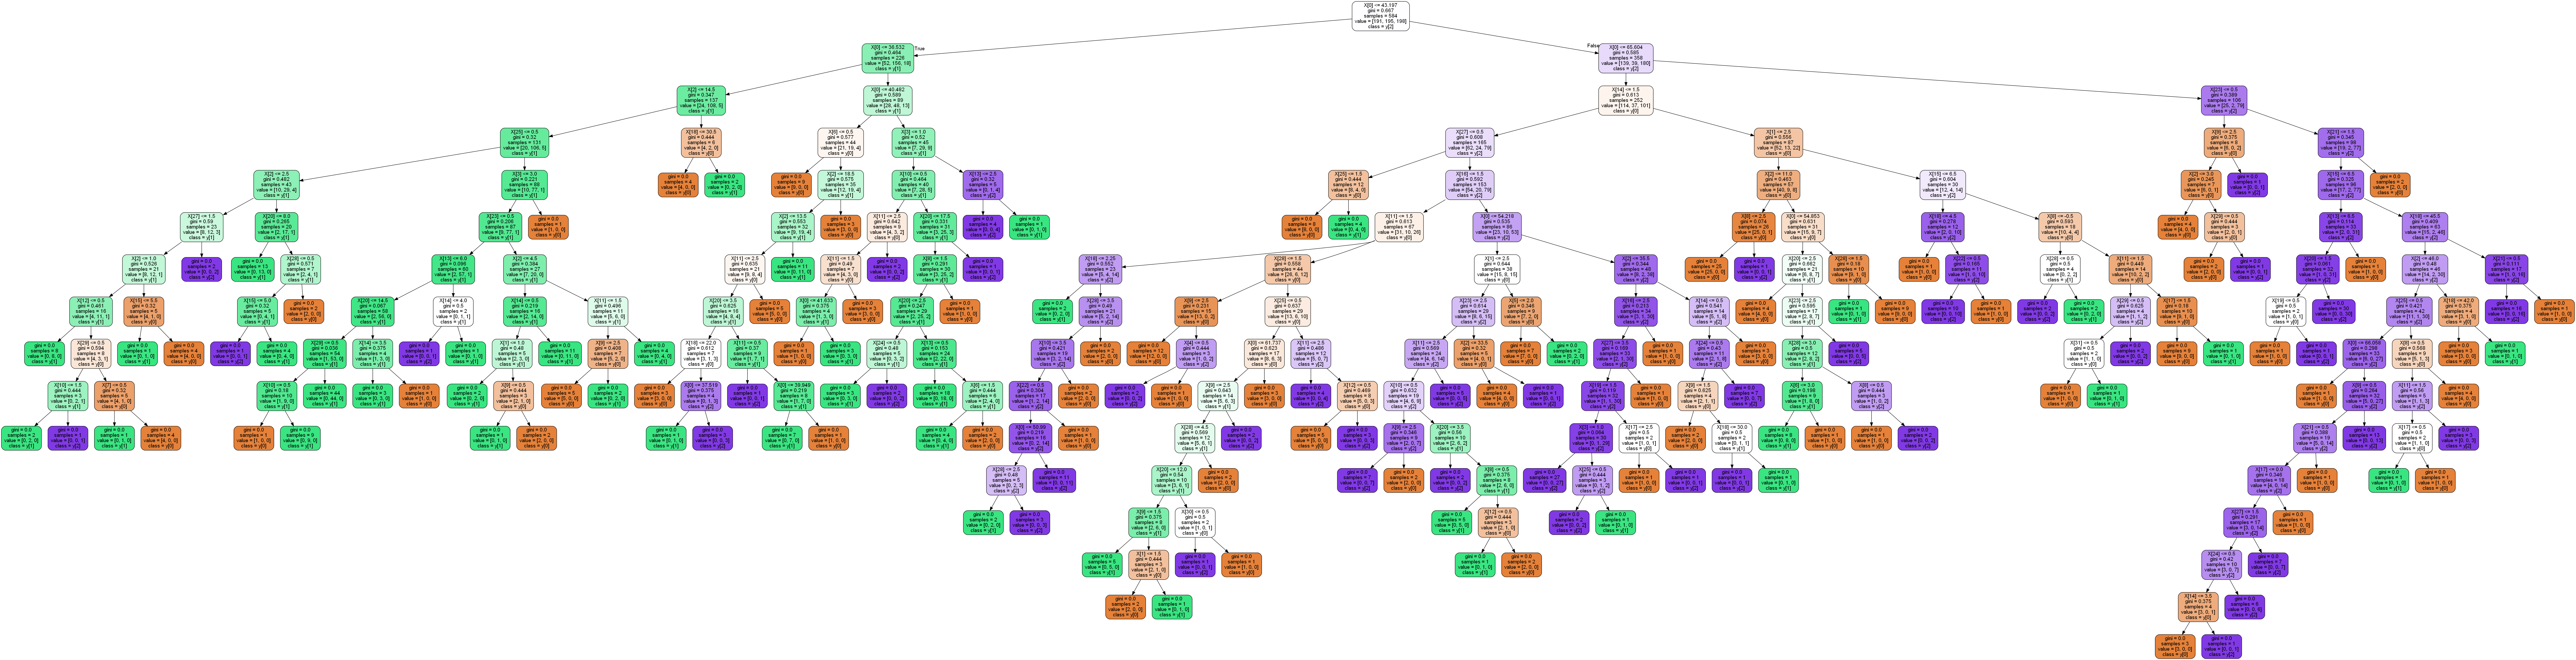

In [4]:
export_graphviz(
    model,
    out_file='tree.dot',
    class_names=True,
    filled=True,
    rounded=True)
# конвертируем из .dot в .png через командую строку
subprocess.call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png'])
# !dot -Tpng 'tree.dot' -o 'tree.png'
display.Image('tree.png')

TypeError: set_ticks() takes 2 positional arguments but 3 were given

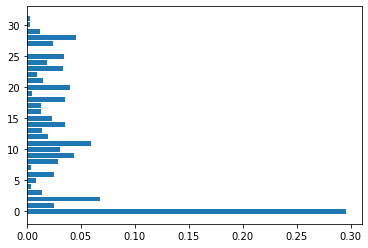

In [5]:
def plot_feature_importances(model, feature_names):
    ax = plt.subplot()
    ax.barh(range(len(model.feature_importances_)), model.feature_importances_, align='center')
    ax.set_yticks(list(range(len(feature_names))), feature_names)
    ax.xlabel('Важность признака')
    ax.ylabel('Признак')

plot_feature_importances(model, feature_names)          